<a href="https://colab.research.google.com/github/pietroduke/DeepFake_Detection/blob/main/STEP4_01_FFpp_train_test_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kết nối Google Colab với Drive và cài đặt các thư viện cần thiết**

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -U git+https://github.com/qubvel/efficientnet
! pip install tensorflow-addons
! pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-x1vk5ssh
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-x1vk5ssh
     |████████████████████████████████| 50 kB 2.8 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=337c26612b7309c7f344af379b4f1eaad84d9312f3cc2226a9b87edadb4d3743
  Stored in directory: /tmp/pip-ephem-wheel-cache-jy61im49/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-q_esxh5d
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-q_esxh5d
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20045 sha256=9efb0d510fb33250e

**Giải nén tệp dữ liệu**

In [ ]:
# !unzip  /content/drive/MyDrive/DatasetCELEB_train.zip
!unzip  /content/drive/MyDrive/DatasetFF_train.zip

**1) Khai báo các thư viện sử dụng**

In [ ]:
import os
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, InputSpec, Layer, BatchNormalization, Convolution2D
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, MaxPooling2D, MaxPooling1D
from tensorflow_addons.layers import SpatialPyramidPooling2D



> **1.1) Đối với DenseNet121 và Xception**



In [ ]:
# from classification_models.tfkeras import Classifiers
# DenseNet121, preprocess_input = Classifiers.get('densenet121')
# get = DenseNet121(
#     weights = 'imagenet',
#     input_shape = (224,224, 3),
#     include_top = False,
# )

# model = Sequential()
# model.add(get)
# model.add(SpatialPyramidPooling2D([1, 2, 4]))
# model.add(Flatten(name="flatten"))
# model.add(Dense(units = 2, activation = 'softmax'))
# model.summary()



> **1.2) Đối với EfficientNetB0 đến EfficientNetB2**



In [ ]:
from efficientnet.tfkeras import EfficientNetB2 #EfficientNetB0, EfficientNetB1, EfficientNetB2
efficient_net = EfficientNetB2(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False,
    pooling = 'max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 1408)             7768562   
 )                                                               
                                                                 
 dense_10 (Dense)            (None, 512)               721408    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 2)                 514       
                                                                 
Total params: 8,621,812
Trainable params: 8,554,244
Non-trainable params: 67,568
_______________________________________

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

**2) Khởi tạo đường dẫn, checkpoint và callbacks**

In [ ]:
train_path = '/content/DatasetFF_train/train'
val_path = '/content/DatasetFF_train/val'

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/model_checkpoint/'
print('Creating Directory: ' + checkpoint_filepath)
os.makedirs(checkpoint_filepath, exist_ok=True)

Creating Directory: /content/drive/MyDrive/model_checkpoint/


In [ ]:
custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 10,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'EfficientNetB2_FF_again.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

**3) ImageDataGenerator**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

val_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)
val_generator = val_datagen.flow_from_directory(
    directory = val_path,
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

Found 69169 images belonging to 2 classes.
Found 17293 images belonging to 2 classes.


In [ ]:
len(train_generator)

2162

**4) Huấn luyện**

In [ ]:
num_epochs = 20

In [ ]:
H = model.fit(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    callbacks = custom_callbacks
)
print(H.history)

Epoch 1/20
2162/2162 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.7791
Epoch 00001: val_loss improved from inf to 0.26939, saving model to /content/drive/MyDrive/model_checkpoint/EfficientNetB2_FF_again.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2162/2162 [==============================] - 913s 412ms/step - loss: 0.4713 - accuracy: 0.7791 - val_loss: 0.2694 - val_accuracy: 0.8865
Epoch 2/20
2162/2162 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.9174
Epoch 00002: val_loss improved from 0.26939 to 0.15220, saving model to /content/drive/MyDrive/model_checkpoint/EfficientNetB2_FF_again.h5
2162/2162 [==============================] - 885s 409ms/step - loss: 0.2061 - accuracy: 0.9174 - val_loss: 0.1522 - val_accuracy: 0.9434
Epoch 3/20
2162/2162 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9451
Epoch 00003: val_loss improved from 0.15220 to 0.10887, saving model to /content/drive/MyDrive/model_checkpoint/EfficientNetB2_FF_again.h5
2162/2162 [==============================] - 887s 410ms/step - loss: 0.1442 - accuracy: 0.9451 - val_loss: 0.1089 - val_accuracy: 0.9577
Epoch 4/20
2162/2162 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9565
Epoch 00004: val_

**5) Plot đồ thị train**

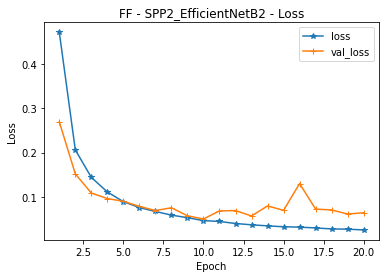

In [ ]:
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

import matplotlib.pyplot as plt
epochs = range(1, len(acc) + 1)
plt.plot(epochs, H.history['loss'], label='loss', marker="*")
plt.plot(epochs, H.history['val_loss'], label='val_loss', marker="+")
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,1])
plt.title('FF - SPP2_EfficientNetB2 - Loss')
plt.legend()
plt.show()

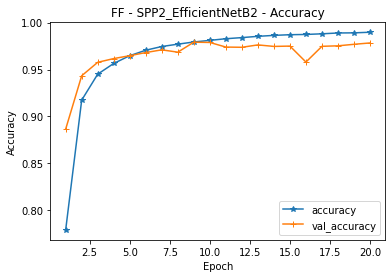

In [ ]:
plt.plot(epochs, H.history['accuracy'], label='accuracy', marker="*")
plt.plot(epochs, H.history['val_accuracy'], label='val_accuracy', marker="+")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0,1])
plt.title('FF - SPP2_EfficientNetB2 - Accuracy')
plt.legend()
plt.show()



---



---



---



---



---



---
**Phần test**


---

---



---



---



---






In [ ]:
!unzip /content/drive/MyDrive/DatasetFF_test.zip
# !unzip /content/drive/MyDrive/DatasetCELEB_test.zip

**1) Khai báo thư viện**

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**2) Khai báo tệp test**

In [ ]:
test_path = '/content/DatasetFF_test'
test_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    classes=['real', 'fake'],
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = None,
    batch_size = 1,
    shuffle = False
)

Found 49366 images belonging to 2 classes.


**3) Load mô hình đã học ở trên**

In [ ]:
# new_model = load_model('/content/drive/MyDrive/model_checkpoint/SPP2_EfficientNetB0_FF_part2.h5',
#                        custom_objects={'SpatialPyramidPooling2D': SpatialPyramidPooling2D})
new_model = load_model('/content/drive/MyDrive/model_checkpoint/EfficientNetB2_FF_again.h5')

**4) Predict tệp dataset**

In [ ]:
test_generator.reset()
preds = new_model.predict(test_generator, verbose = 1)

49366/49366 [==============================] - 1181s 24ms/step


In [ ]:
print(preds)

[[2.7871735e-08 1.0000000e+00]
 [3.2510216e-04 9.9967492e-01]
 [1.2696608e-02 9.8730332e-01]
 ...
 [1.0000000e+00 4.1161106e-09]
 [1.0000000e+00 3.5226669e-11]
 [1.0000000e+00 1.6808286e-08]]


**5) Encoder True Labels (Nên kiểm tra nhãn trước, [0 1] thì set 'real, fake'**

In [ ]:
from keras.utils import np_utils
from imutils import paths
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
import os

path_reals = list(paths.list_images('/content/DatasetFF_test/real'))
labels_real = []

for path_real in path_reals:
	label2 = path_real.split(os.path.sep)[-2]
	labels_real.append(label2)

path_fakes = list(paths.list_images('/content/DatasetFF_test/fake'))
labels_fake = []

for path_fake in path_fakes:
	label3 = path_fake.split(os.path.sep)[-2]
	labels_fake.append(label3)

labels_test = labels_real + labels_fake

In [ ]:
print(labels_test[2])
print(labels_test[30000])

real
fake


In [ ]:
le = LabelEncoder()
labels_test = le.fit_transform(labels_test)
labels_test = np_utils.to_categorical(labels_test, 2)

f = open('le.pickle', "wb")
f.write(pickle.dumps(le))
f.close()

In [ ]:
print(labels_test[2])
print(labels_test[30000])

[0. 1.]
[1. 0.]


**6) Classification Report**

In [ ]:
from sklearn.metrics import classification_report

test = np.argmin(labels_test, axis=1)
pred = np.argmin(preds, axis=1)
print(classification_report(test, pred, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

        fake    0.93299   0.79957   0.86114     26313
        real    0.80333   0.93446   0.86394     23053

    accuracy                        0.86256     49366
   macro avg    0.86816   0.86701   0.86254     49366
weighted avg    0.87244   0.86256   0.86245     49366



In [ ]:
print(test)
print(pred)

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


**7) Confussion Matrix**

[[21039  5274]
 [ 1511 21542]]


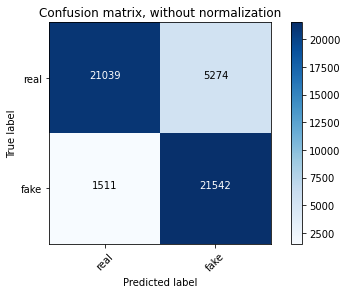

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test, pred)
print(cnf_matrix)
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['real', 'fake']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

**8) EER, TPR, FPR**

In [ ]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(test, pred, pos_label=1)

fnr = 1 - tpr
fpr_eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
fnr_eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
eer = min(fpr_eer, fnr_eer)
print("tpr = ", tpr)
print("fpr = ", fpr)
print("eer = ", eer)

tpr =  [0.         0.93445539 1.        ]
fpr =  [0.         0.20043325 1.        ]
eer =  0.06554461458378524


**9) Đồ thị ROC**

In [ ]:
test = np.argmin(labels_test, axis=1)
true = preds[:, 0]
print(true)

[2.7871735e-08 3.2510216e-04 1.2696608e-02 ... 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


threshold at eer =  0.86851925
eer =  0.11351803291148861


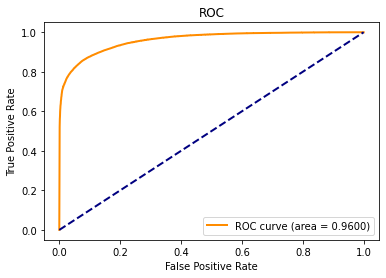

In [ ]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from itertools import cycle

fpr, tpr, threshold = roc_curve(test, true, pos_label=1)
fnr = 1 - tpr
fpr_eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
fnr_eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
eer = min(fpr_eer, fnr_eer)
print("threshold at eer = ", eer_threshold)
print("eer = ", eer)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

**10) Tính TPR 1%, TPR 0.5%, EER, EER_Threshold**

In [ ]:
import numpy as np

from scipy import interpolate

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def cal_metric(groundTruth, predicted):
    fpr, tpr, thresholds = roc_curve(groundTruth, predicted)
    y = (tpr)
    x = (fpr)
    z = tpr + fpr
    tpr = tpr.reshape((tpr.shape[0], 1))
    fpr = fpr.reshape((fpr.shape[0], 1))
    xnew = np.arange(0, 1, 0.0000001)
    func = interpolate.interp1d(x, y)
    # frr = fpr
    ynew = func(xnew)

    znew = abs(xnew + ynew - 1)

    eer = xnew[np.argmin(znew)]
    print('EER =', eer)
    # interpolate thresholds
    func_2 = interpolate.interp1d(x, thresholds)
    thresholds_new = func_2(xnew)

    print("Threshold at eer: {}".format(thresholds_new[np.argmin(znew)]))

    FPR = {"TPR(1.%)": 0.01, "TPR(.5%)": 0.005}

    TPRs = {"TPR(1.%)": 0.01, "TPR(.5%)": 0.005}

    for i, (key, value) in enumerate(FPR.items()):
        index = np.argwhere(xnew == value)

        score = ynew[index]

        TPRs[key] = float(np.squeeze(score))
    #	    print(key, score)

    auc = roc_auc_score(groundTruth, predicted)
    print('AUC = ', auc)
    print ('TPRs = ', TPRs)
    if 1:
        plt.plot(xnew, ynew)
        plt.title("ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return eer, TPRs, auc, {'x': xnew, 'y': ynew}

EER = 0.1135644
Threshold at eer: 0.8684605485496958
AUC =  0.9600444952938663
TPRs =  {'TPR(1.%)': 0.7087071097037262, 'TPR(.5%)': 0.6437396434303562}


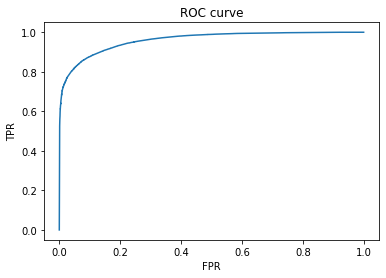

(0.1135644,
 {'TPR(.5%)': 0.6437396434303562, 'TPR(1.%)': 0.7087071097037262},
 0.9600444952938663,
 {'x': array([0.000000e+00, 1.000000e-07, 2.000000e-07, ..., 9.999997e-01,
         9.999998e-01, 9.999999e-01]),
  'y': array([0.00000000e+00, 6.17450223e-05, 1.23490045e-04, ...,
         9.99999999e-01, 9.99999999e-01, 1.00000000e+00])})

In [ ]:
cal_metric(test, true)